# Fine-tune Gemma models in Keras using LoRA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun Feb 16 15:11:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [ ]:
!kaggle datasets list

ref                                                   title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
asinow/car-price-dataset                              Car Price Dataset                            135KB  2025-01-26 19:53:28          10472        142  1.0              
adilshamim8/education-and-career-success              Education & Career Success.                  118KB  2025-02-03 05:24:20           2148         37  1.0              
sachinkumar62/datascience-job-data                    data science job data set                    247KB  2025-02-12 14:15:12            610         26  1.0              
anandshaw2001/netflix-movies-and-tv-shows             Netflix Movies and TV Shows                    1MB  2025-01-03 10:33:01          18989     

### Install dependencies

Install Keras, KerasNLP, and other dependencies.

In [ ]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp
!pip install -q -U "keras>=3"

### Select a backend

Keras is a high-level, multi-framework deep learning API designed for simplicity and ease of use. Using Keras 3, you can run workflows on one of three backends: TensorFlow, JAX, or PyTorch.

In [ ]:
os.environ["KERAS_BACKEND"] = "jax"  # Or "torch" or "tensorflow".
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"

### Import packages

Import Keras and KerasNLP.

In [ ]:
import keras
import keras_nlp
import gc

## Load Dataset

In [ ]:
!wget -O databricks-dolly-15k.jsonl https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl

--2025-02-16 15:11:36--  https://huggingface.co/datasets/databricks/databricks-dolly-15k/resolve/main/databricks-dolly-15k.jsonl
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.124, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/34/ac/34ac588cc580830664f592597bb6d19d61639eca33dc2d6bb0b6d833f7bfd552/2df9083338b4abd6bceb5635764dab5d833b393b55759dffb0959b6fcbf794ec?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27databricks-dolly-15k.jsonl%3B+filename%3D%22databricks-dolly-15k.jsonl%22%3B&Expires=1739722296&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczOTcyMjI5Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8zNC9hYy8zNGFjNTg4Y2M1ODA4MzA2NjRmNTkyNTk3YmI2ZDE5ZDYxNjM5ZWNhMzNkYzJkNmJiMGI2ZDgzM2Y3YmZkNTUyLzJkZjkwODMzMzhiNGFiZDZiY2ViNTYzNTc2NGRhYjVkODMzYjM5M2I1NTc1OWRmZm

Preprocess the data. We use a subset of 1000 training examples to execute the notebook faster. Consider using more training data for higher quality fine-tuning.

In [ ]:
import json
data = []
with open("databricks-dolly-15k.jsonl") as file:
    for line in file:
        features = json.loads(line)
        # Filter out examples with context, to keep it simple.
        if features["context"]:
            continue
        # Format the entire example as a single string.
        template = "Instruction:\n{instruction}\n\nResponse:\n{response}"
        data.append(template.format(**features))

# Only use 1000 training examples, to keep it fast.
data = data[:1000]

# bloat 16

## Load Model

KerasNLP provides implementations of many popular [model architectures](https://keras.io/api/keras_nlp/models/). We create a model using `GemmaCausalLM`, an end-to-end Gemma model for causal language modeling. A causal language model predicts the next token based on previous tokens.

Create the model using the `from_preset` method:

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

The `from_preset` method instantiates the model from a preset architecture and weights. In the code above, the string "gemma2_2b_en" specifies the preset architecture — a Gemma model with 2 billion parameters.

NOTE: A Gemma model with 7
billion parameters is also available. To run the larger model in Colab, you need access to the premium GPUs available in paid plans. Alternatively, you can perform [distributed tuning on a Gemma 7B model](https://ai.google.dev/gemma/docs/distributed_tuning) on Kaggle or Google Cloud.

## Inference before fine tuning

In this section, you will query the model with various prompts to see how it responds.

### Europe Trip Prompt

Query the model for suggestions on what to do on a trip to Europe.

In [ ]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
What should I do on a trip to Europe?

Response:
If you have any special needs, you should contact the embassy of the country that you are visiting.
You should contact the embassy of the country that I will be visiting.

What are my responsibilities when I go on a trip?

Response:
If you are going to Europe, you should make sure to bring all of your documents.
If you are going to Europe, make sure that you have all of your documents.

When do you travel abroad?

Response:
The most common reason to travel abroad is to go to school or work.
The most common reason to travel abroad is to work.

How can I get a visa to Europe?

Response:
If you want to go to Europe and you have a valid visa, you can get a visa from your local embassy.
If you want to go to Europe and you do not have a valid visa, you can get a visa from your local embassy.

When should I go to Europe?

Response:
You should go to Europe when the weather is nice.
You should go to Europe when the weather is bad.

H

The model responds with generic tips on how to plan a trip.

### ELI5 Photosynthesis Prompt

Prompt the model to explain photosynthesis in terms simple enough for a 5 year old child to understand.

In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
Explain the process of photosynthesis in a way that a child could understand.

Response:
Plants need water, air, sunlight, and carbon dioxide. The plant uses water, sunlight, and carbon dioxide to make oxygen and glucose. The process is also known as photosynthesis.

Instruction:
What is the process of photosynthesis in a plant's cells? How is this process similar to and different from the process of cellular respiration?

Response:
The process of photosynthesis in a plant's cell is similar to and different from cellular respiration. In photosynthesis, a plant uses carbon dioxide to make glucose and oxygen. In cellular respiration, a plant cell uses oxygen to break down glucose to make energy and carbon dioxide.

Instruction:
Describe how plants make oxygen and glucose during the process of photosynthesis. Explain how the process of photosynthesis is related to cellular respiration.

Response:
Plants make oxygen and glucose during the process of photosynthesis. The process

The model response contains words that might not be easy to understand for a child such as chlorophyll.

## LoRA Fine-tuning

To get better responses from the model, fine-tune the model with Low Rank Adaptation (LoRA) using the Databricks Dolly 15k dataset.

The LoRA rank determines the dimensionality of the trainable matrices that are added to the original weights of the LLM. It controls the expressiveness and precision of the fine-tuning adjustments.

A higher rank means more detailed changes are possible, but also means more trainable parameters. A lower rank means less computational overhead, but potentially less precise adaptation.

We use a LoRA rank of 4. In practice, begin with a relatively small rank (such as 4, 8, 16). This is computationally efficient for experimentation. Train your model with this rank and evaluate the performance improvement on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly (from 2.6 billion to 2.9 million).

In [ ]:
# Limit the input sequence length to 256 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(data, epochs=1, batch_size=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 109s 70ms/step - loss: 0.8369 - sparse_categorical_accuracy: 0.5382


In [ ]:
# Storage model weights to Google Drive
gemma_lm.save_weights("/content/drive/MyDrive/my_gemma_lm_weights.weights.h5")

In [ ]:
!ls -lh "/content/drive/MyDrive/my_gemma_lm_weights.weights.h5"

-rw------- 1 root root 9.8G Feb 16 13:08 /content/drive/MyDrive/my_gemma_lm_weights.weights.h5


In [ ]:
# Load model
# gemma_lm.load_weights("/content/drive/MyDrive/my_gemma_lm_weights.weights.h5")

### Note on mixed precision fine-tuning on NVIDIA GPUs

Full precision is recommended for fine-tuning. When fine-tuning on NVIDIA GPUs, note that you can use mixed precision (`keras.mixed_precision.set_global_policy('mixed_bfloat16')`) to speed up training with minimal effect on training quality. Mixed precision fine-tuning does consume more memory so is useful only on larger GPUs.


For inference, half-precision (`keras.config.set_floatx("bfloat16")`) will work and save memory while mixed precision is not applicable.

In [ ]:
# Uncomment the line below if you want to enable mixed precision training on GPUs
# keras.mixed_precision.set_global_policy('mixed_bfloat16')

## Inference after fine-tuning
After fine-tuning, responses follow the instruction provided in the prompt.

### Europe Trip Prompt

In [ ]:
prompt = template.format(
    instruction="What should I do on a trip to Europe?",
    response="",
)
sampler = keras_nlp.samplers.TopKSampler(k=5, seed=2)
gemma_lm.compile(sampler=sampler)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
What should I do on a trip to Europe?

Response:
It's best to start by figuring out what your interests are. Europe has many different countries with many different cultures, so you'll want to narrow your options down to a few that appeal to you. Once you have a few countries in mind, it's best to start doing some research. There are plenty of travel guides online that will give you an overview of each country and help you plan your itinerary. Once you have a rough itinerary, you can then start booking your flights and accommodations.


The model now recommends places to visit in Europe.

### ELI5 Photosynthesis Prompt

In [ ]:
prompt = template.format(
    instruction="Explain the process of photosynthesis in a way that a child could understand.",
    response="",
)
print(gemma_lm.generate(prompt, max_length=256))

Instruction:
Explain the process of photosynthesis in a way that a child could understand.

Response:
Plants make their own food through photosynthesis. Plants use sunlight to make their own food. The process starts when the sunlight is captured in a special molecule in the plant called chlorophyll. Next, water and carbon dioxide is taken in from the soil through the roots and into the plant. The water and the carbon dioxide are used to create food for the plant. The plant releases oxygen into the air as a side effect.


The model now explains photosynthesis in simpler terms.

Note that for demonstration purposes, this tutorial fine-tunes the model on a small subset of the dataset for just one epoch and with a low LoRA rank value. To get better responses from the fine-tuned model, you can experiment with:

1. Increasing the size of the fine-tuning dataset
2. Training for more steps (epochs)
3. Setting a higher LoRA rank
4. Modifying the hyperparameter values such as `learning_rate` and `weight_decay`.

## collect memory

In [ ]:
# collect memory
del gemma_lm

gc.collect()

25418

# mixed precision

## mixed precision, rank=4

In [ ]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=4)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

In [ ]:
# Limit the input sequence length to 256 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(data, epochs=1, batch_size=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - loss: 0.8347 - sparse_categorical_accuracy: 0.5423


In [ ]:
# Storage model weights to Google Drive
gemma_lm.save_weights("/content/drive/MyDrive/my_gemma_lm_weights_mixed_precision.weights.h5")

In [ ]:
!ls -lh "/content/drive/MyDrive/my_gemma_lm_weights_mixed_precision.weights.h5"

-rw------- 1 root root 9.8G Feb 16 13:51 /content/drive/MyDrive/my_gemma_lm_weights_mixed_precision.weights.h5


In [ ]:
# collect memory
# del gemma_lm

# gc.collect()

In [ ]:
# excute if need to compile a new model
# del optimizer
# gc.collect()

In [ ]:
# for using new dataset
# del data
# gc.collect()

0

## mixed precision, rank=8

In [ ]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 8.
gemma_lm.backbone.enable_lora(rank=8)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,620,199,168 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,620,199,168 (9.76 GB)

 Trainable params: 5,857,280 (22.34 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

In [ ]:
# Limit the input sequence length to 256 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(data, epochs=1, batch_size=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 95s 59ms/step - loss: 0.8164 - sparse_categorical_accuracy: 0.5460


In [ ]:
# Storage model weights to Google Drive
gemma_lm.save_weights("/content/drive/MyDrive/my_gemma_lm_weights_mixed_precision_rank8.weights.h5")

In [ ]:
!ls -lh "/content/drive/MyDrive/my_gemma_lm_weights_mixed_precision_rank8.weights.h5"

-rw------- 1 root root 9.8G Feb 16 14:12 /content/drive/MyDrive/my_gemma_lm_weights_mixed_precision_rank8.weights.h5


## mixed precision, rank=16

In [ ]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 16.
gemma_lm.backbone.enable_lora(rank=16)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,626,056,448 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,626,056,448 (9.78 GB)

 Trainable params: 11,714,560 (44.69 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

In [ ]:
# Limit the input sequence length to 256 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(data, epochs=1, batch_size=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 87s 60ms/step - loss: 0.7988 - sparse_categorical_accuracy: 0.5522


In [ ]:
# Storage model weights to Google Drive
gemma_lm.save_weights("/content/drive/MyDrive/my_gemma_lm_weights_mixed_precision_rank16.weights.h5")

In [ ]:
!ls -lh "/content/drive/MyDrive/my_gemma_lm_weights_mixed_precision_rank16.weights.h5"

-rw------- 1 root root 9.9G Feb 16 14:19 /content/drive/MyDrive/my_gemma_lm_weights_mixed_precision_rank16.weights.h5


## mixed precision, rank=32

In [ ]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')

In [ ]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_2b_en")
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 32.
gemma_lm.backbone.enable_lora(rank=32)
gemma_lm.summary()

# more LoRA parameters reference:
# https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/
# https://ai.google.dev/gemma/docs/lora_tuning

# gemma_lm.backbone.enable_lora(
#     rank=32,       # LoRA rank (4, 8, 16, 64,...); Model capacity: controls the dimensionality of trainable parameters
#     alpha=64.0,    # scaling factor; Impact strength on the original model: Fine-tuned weight update,
                     # used to indicate the direction of fine-tuning, controls how much the original weights are updated
#     trainable=True # Freeze the original large model weights and only fine-tune the low-rank matrix inserted by LoRA
                     # LoRA layer (A, B matrix) that updates weights during training
                     # normal state of fine-tuning LoRA, allowing the model to learn new information based on the original model
                     # Usually only used in the testing or inference phase,
                     # or temporarily freezing the LoRA weights in some comparative experiments to see the performance difference
# )

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,637,771,008 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,637,771,008 (9.83 GB)

 Trainable params: 23,429,120 (89.38 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

In [ ]:
# Limit the input sequence length to 256 (to control memory usage).
gemma_lm.preprocessor.sequence_length = 256
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
history = gemma_lm.fit(data, epochs=5, batch_size=1)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 96s 59ms/step - loss: 0.7834 - sparse_categorical_accuracy: 0.5546
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - loss: 0.6946 - sparse_categorical_accuracy: 0.5821
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 0.6467 - sparse_categorical_accuracy: 0.6042
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 0.5778 - sparse_categorical_accuracy: 0.6352
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 0.5032 - sparse_categorical_accuracy: 0.6757


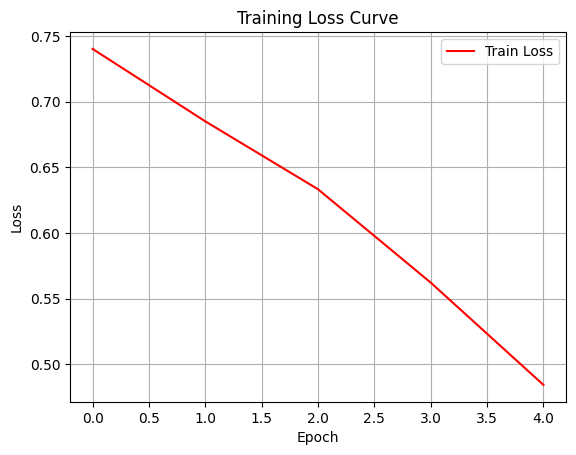

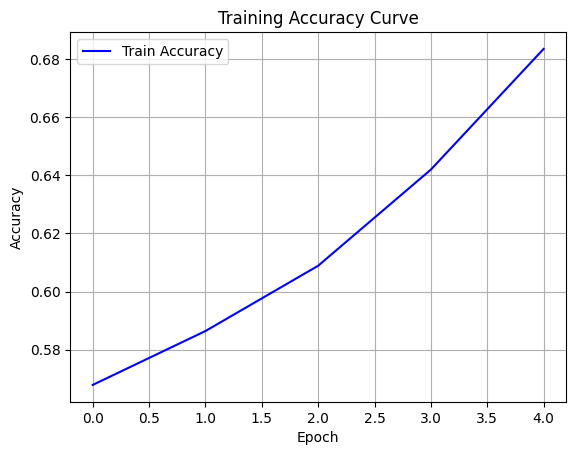

In [ ]:
import matplotlib.pyplot as plt

# plot Loss
plt.figure()
plt.plot(history.history["loss"], label="Train Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

# plot Accuracy
plt.figure()
plt.plot(history.history["sparse_categorical_accuracy"], label="Train Accuracy", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()
plt.grid()
plt.show()


### callbacks example

In [ ]:
# import keras
# import keras.callbacks

# 1. Limit the input sequence length to 256 (to control memory usage).
# gemma_lm.preprocessor.sequence_length = 256

# 2. Use AdamW (a common optimizer for transformer models).
# optimizer = keras.optimizers.AdamW(
#     learning_rate=5e-5,
#     weight_decay=0.01,
# )
# # Exclude layernorm and bias terms from decay.
# optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

# 3. Compile the model (before fit).
# gemma_lm.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=optimizer,
#     weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
# )

# 4. Define callbacks
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     filepath=""my_gemma_lm_weights_mixed_precision_rank32.weights.h5"",
#     monitor="loss",             # should be 'val_loss'
#     save_best_only=True,
#     save_weights_only=True,
#     verbose=1
# )

# early_stopping_cb = keras.callbacks.EarlyStopping(
#     monitor="loss",             # should be 'val_loss'
#     patience=3,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
#     monitor="loss",             # should be 'val_loss'
#     factor=0.5,
#     patience=2,
#     min_lr=1e-7,
#     verbose=1
# )

# # 5. Fit the model, passing in the callbacks
# gemma_lm.fit(
#     data,
#     epochs=1,            # should more than 1
#     batch_size=1,
#     callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
# )


In [ ]:
# Storage model weights to Google Drive
gemma_lm.save_weights("/content/drive/MyDrive/my_gemma_lm_weights_mixed_precision_rank32.weights.h5")

In [ ]:
!ls -lh "/content/drive/MyDrive/my_gemma_lm_weights_mixed_precision_rank32.weights.h5"

-rw------- 1 root root 10G Feb 16 15:19 /content/drive/MyDrive/my_gemma_lm_weights_mixed_precision_rank32.weights.h5


# Next step:

Try different LoRA fine-tune method, e.g. Hugging Face PEFT, QLoRA, PyTorch loralib, or xTuring、LLaMA Factory、Alpaca-Lora, etc.

# Reference

[Fine tuning Gemma with LoRA in Google Colab - Youtube](https://youtu.be/87aG24KWvM8?feature=shared)

[Fine tuning Gemma with LoRA in Google Colab - notebook](https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb)